In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

import random
from random import randint

import glob
import os
import time
import cv2

In [43]:
patch_size = 48 # patches are 64x64
n_patches = 200
eps = 0.00316


def preprocess_diffuse(diffuse, albedo):
    return diffuse / (albedo + eps)


def preprocess_specular(specular):
    assert(np.sum(specular < 0) == 0)
    return np.log(specular + 1)



def gradients(data):
    h, w, c = data.shape
    dX = data[:, 1:, :] - data[:, :w - 1, :]
    dY = data[1:, :, :] - data[:h - 1, :, :]

    dX = np.concatenate((np.zeros([h,1,c], dtype=np.float32),dX), axis=1)
    dY = np.concatenate((np.zeros([1,w,c], dtype=np.float32),dY), axis=0)

    return np.concatenate((dX, dY), axis=2)

def remove_channels(data, channels):
    for c in channels:
        if c in data:
            del data[c]
        else:
            print("Channel {} not found in data!".format(c))


def preprocess_input(inp, debug=False):

    data = {}
    

    data['gradAlbedo'] = gradients(inp['albedo'][:, :, :3].copy())
    data['origAlbedo'] = inp['albedo'].copy()

    data['finalGt'] = np.concatenate((inp['gt-default'], preprocess_diffuse(inp['gt-diff'],inp['albedo']), preprocess_specular(inp['gt-spec'])), axis=2)
    data['finalInput'] = inp['default']

    a = preprocess_diffuse(inp['diff'],inp['albedo'])
    b = preprocess_specular(inp['spec'])
    data['diffuse'] = np.concatenate((a, gradients(a[:, :, :3].copy()), inp['diffVar']), axis=2)
    data['specular'] = np.concatenate((b, gradients(b[:, :, :3].copy()), inp['specVar']), axis=2)
    data['normal'] = gradients(inp['normal'][:, :, :3].copy())
    data['depth'] = gradients(inp['depth'][:, :, :1].copy())
    
    data['X_diff'] = np.concatenate((data['diffuse'],
                           data['normal'],
                           data['depth'],
                           data['gradAlbedo']),axis=2)
    
                                      
    data['X_spec'] = np.concatenate((data['specular'],
                           data['normal'],
                           data['depth'],
                           data['gradAlbedo']),axis=2)
    
    remove_channels(data, ('depth','diffuse', 'specular', 'gradAlbedo'))
    

    
    return data

In [5]:
folder = ['32spp','128spp']
sub = [['default', 'albedo','normal', 'depth', 'diff', 'spec','diffVar','specVar'], ['gt-default', 'gt-spec', 'gt-diff']]


for i in range(1):
    temp = {}
    f = folder[0]
    s = sub[0]
    for chan in s:
        path = os.path.join(f, chan)
        filenames = os.listdir(path)
        path = os.path.join(path, filenames[0])
        temp[chan] = plt.imread(path)

    f = folder[1]
    s = sub[1]
    for chan in s:
        path = os.path.join(f, chan)
        filenames = os.listdir(path)
        path = os.path.join(path, filenames[0])
        temp[chan] = plt.imread(path)

In [27]:
def getVarianceMap(data, patch_size, relative=False):


    if data.ndim < 3:
        data = data[:,:,np.newaxis]


    mean = ndimage.uniform_filter(data, size=(patch_size, patch_size, 1))
    sqrmean = ndimage.uniform_filter(data**2, size=(patch_size, patch_size, 1))
    variance = np.maximum(sqrmean - mean**2, 0)


    if relative:
        variance = variance/np.maximum(mean**2, 1e-2)

    variance = variance.max(axis=2)
    variance = np.minimum(variance**(1.0/2.2), 1.0)

    return variance/variance.max()


def getImportanceMap(buffers, metrics, weights, patch_size):
    if len(metrics) != len(buffers):
        metrics = [metrics[0]]*len(buffers)
    if len(weights) != len(buffers):
        weights = [weights[0]]*len(buffers)
    impMap = None
    for buf, metric, weight in zip(buffers, metrics, weights):
        if metric == 'uniform':
            cur = np.ones(buf.shape[:2], dtype=np.float)
        elif metric == 'variance':
            cur = getVarianceMap(buf, patch_size, relative=False)
        elif metric == 'relvar':
            cur = getVarianceMap(buf, patch_size, relative=True)
        else:
            print('Unexpected metric:', metric)
        if impMap is None:
            impMap = cur*weight
        else:
            impMap += cur*weight
    return impMap / impMap.max()


def samplePatchesProg(img_dim, patch_size, n_samples, maxiter=5000):

    full_area = float(img_dim[0]*img_dim[1])
    sample_area = full_area/n_samples


    radius = np.sqrt(sample_area/np.pi)
    minsqrdist = (2*radius)**2

    def get_sqrdist(x, y, patches):
        if len(patches) == 0:
            return np.infty
        dist = patches - [x, y]
        return np.sum(dist**2, axis=1).min()

    rate = 0.96
    patches = np.zeros((n_samples,2), dtype=int)
    xmin, xmax = 0, img_dim[1] - patch_size[1] - 1
    ymin, ymax = 0, img_dim[0] - patch_size[0] - 1
    for patch in range(n_samples):
        done = False
        while not done:
            for i in range(maxiter):
                x = randint(xmin, xmax)
                y = randint(ymin, ymax)
                sqrdist = get_sqrdist(x, y, patches[:patch,:])
                if sqrdist > minsqrdist:
                    patches[patch,:] = [x, y]
                    done = True
                    break
            if not done:
                radius *= rate
                minsqrdist = (2*radius)**2

    return patches

  
def prunePatches(shape, patches, patchsize, imp):

    pruned = np.empty_like(patches)

    def get_regions_list(shape, step):
        regions = []
        for y in range(0, shape[0], step):
            if y//step % 2 == 0:
                xrange = range(0, shape[1], step)
            else:
                xrange = reversed(range(0, shape[1], step))
            for x in xrange:
                regions.append((x, x + step, y, y + step))
        return regions


    def split_patches(patches, region):
        cur = np.empty_like(patches)
        rem = np.empty_like(patches)
        ccount, rcount = 0, 0
        for i in range(patches.shape[0]):
            x, y = patches[i,0], patches[i,1]
            if region[0] <= x < region[1] and region[2] <= y < region[3]:
                cur[ccount,:] = [x,y]
                ccount += 1
            else:
                rem[rcount,:] = [x,y]
                rcount += 1
        return cur[:ccount,:], rem[:rcount,:]

    rem = np.copy(patches)
    count, error = 0, 0
    for region in get_regions_list(shape, 4*patchsize):
        cur, rem = split_patches(rem, region)
        for i in range(cur.shape[0]):
            x, y = cur[i,0], cur[i,1]
            if imp[y,x] - error > random.random():
                pruned[count,:] = [x, y]
                count += 1
                error += 1 - imp[y,x]
            else:
                error += 0 - imp[y,x]

    return pruned[:count,:]
  
def importanceSampling(data, debug=False):
    global patch_size, n_patches
  
    buffers = []
    for b in ['finalGt', 'normal']:
        buffers.append(data[b][:,:,:3])


    metrics = ['relvar', 'variance']
    weights = [1.0, 1.0]
    imp = getImportanceMap(buffers, metrics, weights, patch_size)

    if debug:
        print("Importance map:")
        plt.figure(figsize = (5,5))
        imgplot = plt.imshow(imp)
        imgplot.axes.get_xaxis().set_visible(False)
        imgplot.axes.get_yaxis().set_visible(False)
        plt.show()

    patches = samplePatchesProg(buffers[0].shape[:2], (patch_size, patch_size), n_patches)
  
    if debug:
        print("Patches:")
        plt.figure(figsize=(15, 10))
        plt.scatter(list(a[0] for a in patches), list(a[1] for a in patches))
        plt.show()
  
    selection = buffers[0] * 0.1
    for i in range(patches.shape[0]):
        x, y = patches[i,0], patches[i,1]
        selection[y:y+patch_size,x:x+patch_size,:] = buffers[0][y:y+patch_size,x:x+patch_size,:]

  
      

    pad = patch_size // 2
    pruned = np.maximum(0, prunePatches(buffers[0].shape[:2], patches + pad, patch_size, imp) - pad)
    selection = buffers[0]*0.1
    for i in range(pruned.shape[0]):
        x, y = pruned[i,0], pruned[i,1]
        selection[y:y+patch_size,x:x+patch_size,:] = buffers[0][y:y+patch_size,x:x+patch_size,:]

    if debug:
        print("After pruning:")
        plt.figure(figsize=(15, 10))
        plt.scatter(list(a[0] for a in pruned), list(a[1] for a in pruned))
        plt.show()
      
    return (pruned + pad)

In [28]:
def crop(data, pos, patch_size):
    half_patch = patch_size // 2
    sx, sy = half_patch, half_patch
    px, py = pos
    return {key: val[(py-sy):(py+sy+1),(px-sx):(px+sx+1),:] 
          for key, val in data.items()}

def get_cropped_patches(inp, debug=False):
    data = preprocess_input(inp)
    patches = importanceSampling(data,debug)
    cropped = list(crop(data, tuple(pos), patch_size) for pos in patches)

    return cropped


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def to_torch_tensors(data):
    if isinstance(data, dict):
        for k, v in data.items():
            if not isinstance(v, torch.Tensor):
                data[k] = torch.from_numpy(v)
    elif isinstance(data, list):
        for i, v in enumerate(data):
            if not isinstance(v, torch.Tensor):
                data[i] = to_torch_tensors(v)
    
    return data
 
def send_to_device(data, device):
    if isinstance(data, dict):
        for k, v in data.items():
            if isinstance(v, torch.Tensor):
                data[k] = v.to(device)
    elif isinstance(data, list):
        for i, v in enumerate(data):
            if isinstance(v, torch.Tensor):
                data[i] = v.to(device)
    
    return data
     

cuda:0


In [44]:
class KPCNDataset(torch.utils.data.Dataset):
    def __init__(self,split=127):
        self.folder = ['32spp','128spp']
        self.sub = [['default', 'albedo','normal', 'depth', 'diff', 'spec','diffVar','specVar'], ['gt-default', 'gt-spec', 'gt-diff']]
        np.random.seed(12)
        self.per = np.random.permutation(split)
        self.split = split
        
        self.cropped = []
        
        for i in range(120):
            temp = {}
            f = self.folder[0]
            s = self.sub[0]
            for chan in s:
                path = os.path.join(f, chan)
                filenames = os.listdir(path)
                path = os.path.join(path, filenames[self.per[i]])
                temp[chan] = plt.imread(path)
                
            f = self.folder[1]
            s = self.sub[1]
            for chan in s:
                path = os.path.join(f, chan)
                filenames = os.listdir(path)
                path = os.path.join(path, filenames[self.per[i]])
                temp[chan] = plt.imread(path)
            self.cropped += get_cropped_patches(temp)
        self.cropped = to_torch_tensors(self.cropped)

    def __len__(self):
        return len(self.cropped)

    def __getitem__(self, idx):
        
        return self.cropped[idx]

dataset = KPCNDataset()

In [45]:
len(dataset)

8475

In [46]:
mode = 'KPCN' 
recon_kernel_size = 17

L = 9 
n_kernels = 100 # number of kernels 
kernel_size = 5 # size of kernel

input_channels = 26
hidden_channels = 100

print("Input channels:", input_channels)

# BHWC -> BCHW
permutation = [0, 3, 1, 2]

Input channels: 26


In [60]:

def make_net(n_layers, mode):

    layers = [
      nn.Conv2d(input_channels, hidden_channels, kernel_size),
      nn.ReLU()
    ]
  
    for l in range(n_layers-2):
        layers += [
          nn.Conv2d(hidden_channels, hidden_channels, kernel_size),
          nn.ReLU()
        ]
    
    params = sum(p.numel() for p in layers[-2].parameters() if p.requires_grad)
    print(params)
    
    out_channels = recon_kernel_size**2
    layers += [nn.Conv2d(hidden_channels, out_channels, kernel_size)]#, padding=18)]
  
    for layer in layers:
        if isinstance(layer, nn.Conv2d):
            nn.init.xavier_uniform_(layer.weight)
  
    return nn.Sequential(*layers)


def crop_like(data, like, debug=False):
    if data.shape[-2:] != like.shape[-2:]:
        # crop
        with torch.no_grad():
            dx, dy = data.shape[-2] - like.shape[-2], data.shape[-1] - like.shape[-1]
            data = data[:,:,dx//2:-dx//2,dy//2:-dy//2]
        if debug:
            print(dx, dy)
            print("After crop:", data.shape)
    return data

def apply_kernel(weights, data):

    weights = weights.permute((0, 2, 3, 1)).to(device)
    _, _, h, w = data.size()
    weights = F.softmax(weights, dim=3).view(-1, w * h, recon_kernel_size, recon_kernel_size)


    r = recon_kernel_size // 2
    data = F.pad(data[:,:3,:,:], (r,) * 4, "reflect")
    

    R = []
    G = []
    B = []
    kernels = []
    for i in range(h):
        for j in range(w):
            pos = i*h+j
            ws = weights[:,pos:pos+1,:,:]
            kernels += [ws, ws, ws]
            sy, ey = i+r-r, i+r+r+1
            sx, ex = j+r-r, j+r+r+1
            R.append(data[:,0:1,sy:ey,sx:ex])
            G.append(data[:,1:2,sy:ey,sx:ex])
            B.append(data[:,2:3,sy:ey,sx:ex])

        
    reds = (torch.cat(R, dim=1).to(device)*weights).sum(2).sum(2)
    greens = (torch.cat(G, dim=1).to(device)*weights).sum(2).sum(2)
    blues = (torch.cat(B, dim=1).to(device)*weights).sum(2).sum(2)
    
    res = torch.cat((reds, greens, blues), dim=1).view(-1, 3, h, w).to(device)
    
    return res



def train(mode='KPCN', epochs=10, learning_rate=1e-5, debug=False):

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                          shuffle=True, num_workers=0)
    
    model_diff = make_net(L, mode).to('cuda:0')
    model_spec = make_net(L, mode).to('cuda:0')

    print(model_diff, "CUDA:", next(model_diff.parameters()).is_cuda)

    criterion = nn.L1Loss()

    optimizer_diff = optim.Adam(model_diff.parameters(), lr=learning_rate)
    optimizer_spec = optim.Adam(model_spec.parameters(), lr=1e-4)
    
    #scheduler1 = optim.lr_scheduler.StepLR(optimizer_diff, step_size = 5, gamma = 0.1)
    #scheduler2 = optim.lr_scheduler.StepLR(optimizer_spec, step_size = 5, gamma = 0.1)
    
    start = time.time()

    for epoch in range(epochs):
        diffLoss = 0
        specLoss = 0
        
        for i_batch, sample_batched in enumerate(train_loader):

            X = sample_batched['X_diff'].permute(permutation).to(device)
            Y = sample_batched['finalGt'][:,:,:,3:6].permute(permutation).to(device)

            optimizer_diff.zero_grad()

            out = model_diff(X)

            X_input = crop_like(X, out)
            out = apply_kernel(out, X_input)

            Y = crop_like(Y, out)

            loss = criterion(out, Y)
            loss.backward()
            optimizer_diff.step()
            diffLoss += loss.item()
            

            X = sample_batched['X_spec'].permute(permutation).to(device)
            Y = sample_batched['finalGt'][:,:,:,6:].permute(permutation).to(device)

            optimizer_spec.zero_grad()

            out = model_spec(X)

            X_input = crop_like(X, out)
            out = apply_kernel(out, X_input)

            Y = crop_like(Y, out)

            loss = criterion(out, Y)
            loss.backward()
            optimizer_spec.step()
            specLoss += loss.item()
            
            if i_batch % 150 == 149:
                print("Epoch {}".format(epoch + 1))
                print("Batch {}".format(i_batch + 1))
                print("Diff loss: {}".format(diffLoss/150))
                print("Spec loss: {}".format(specLoss/150))
                diffLoss = 0
                specLoss = 0
    
        
        #scheduler1.step()
        #scheduler2.step()
        name1 = 'diff' + str(epoch) + '.pt'
        name2 = 'spec' + str(epoch) + '.pt'
        torch.save(model_diff.state_dict(), name1)
        torch.save(model_spec.state_dict(), name2)
    print('Finished training in mode', mode)
    print('Took', time.time() - start, 'seconds.')
  
    return model_diff, model_spec

In [61]:
modeld, models = train(mode='KPCN', epochs=8, learning_rate=1e-5)

250100
250100
Sequential(
  (0): Conv2d(26, 100, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (11): ReLU()
  (12): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (13): ReLU()
  (14): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (15): ReLU()
  (16): Conv2d(100, 289, kernel_size=(5, 5), stride=(1, 1))
) CUDA: True
Epoch 1
Batch 150
Diff loss: 0.021383402577290933
Spec loss: 0.013596429508179426
Epoch 1
Batch 300
Diff loss: 0.015307675674557686
Spec loss: 0.011598952279115716
Epoch 1
Batch 450
Diff loss: 0.015029141642153264
Spec loss: 0.011620519782106082
Epoch 2
Batch 150
Diff loss: 0.014659497042497
Spec loss: 0.011262

In [59]:
def unsqueeze_all(d):
    for k, v in d.items():
        d[k] = torch.unsqueeze(v, dim=0)
    return d

def denoise(diffuseNet, specularNet, data, debug=False):
   
    with torch.no_grad():
        mode = 'KPCN'
        criterion = nn.L1Loss()

        data = to_torch_tensors(data)
        if len(data['X_diff'].size()) != 4:
            data = unsqueeze_all(data)

        print(data['X_diff'].size())

        X_diff = data['X_diff'].permute(permutation).to(device)
        Y_diff = data['finalGt'][:,:,:,3:6].permute(permutation).to(device)

        outputDiff = diffuseNet(X_diff)


        X_input = crop_like(X_diff, outputDiff)
        outputDiff = apply_kernel(outputDiff, X_input)

        Y_diff = crop_like(Y_diff, outputDiff)

        lossDiff = criterion(outputDiff, Y_diff).item()

        X_spec = data['X_spec'].permute(permutation).to(device)
        Y_spec = data['finalGt'][:,:,:,6:].permute(permutation).to(device)

        outputSpec = specularNet(X_spec)

        X_input = crop_like(X_spec, outputSpec)
        outputSpec = apply_kernel(outputSpec, X_input)

        Y_spec = crop_like(Y_spec, outputSpec)

        lossSpec = criterion(outputSpec, Y_spec).item()

        albedo = data['origAlbedo'].permute(permutation).to(device)
        albedo = crop_like(albedo, outputDiff)
        outputFinal = outputDiff * (albedo + eps) + torch.exp(outputSpec) - 1.0

        if True:
            print("Sample, denoised, gt")
            sz = 7
            orig = crop_like(data['finalInput'].permute(permutation), outputFinal)
            orig = orig.cpu().permute([0, 2, 3, 1]).numpy()[0,:]
            show_data(orig, figsize=(sz,sz))
            img = outputFinal.cpu().detach().permute([0, 2, 3, 1]).numpy()[0,:]
            show_data(img, figsize=(sz,sz))
            gt = crop_like(data['finalGt'][:,:,:,:3].permute(permutation), outputFinal)
            gt = gt.cpu().permute([0, 2, 3, 1]).numpy()[0,:]
            show_data(gt, figsize=(sz,sz))

        if debug:
            print("LossDiff:", lossDiff)
            print("LossSpec:", lossSpec)
    

    

In [56]:
def show_data(data, figsize=(5,5)):

    plt.figure(figsize=figsize)
    imgplot = plt.imshow(data, aspect='equal')
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()

In [48]:
#torch.save(kmodel.state_dict(), 'kmodel.pt')

In [9]:
kmodel = make_net(9, mode).to(device)
kmodel.load_state_dict(torch.load('kmodel.pt'))

90100


<All keys matched successfully>

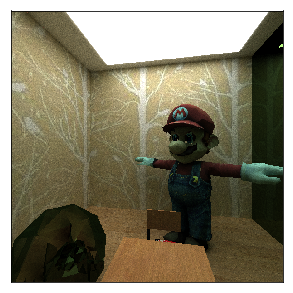

In [62]:
np.random.seed(12)
per = np.random.permutation(127)
i = 0 #per[81]
temp = {}
f = '32spp'
for chan in ['default', 'albedo','normal', 'depth', 'diff', 'spec','specVar','diffVar']:
    
    path = os.path.join(f, chan)
    filenames = os.listdir(path)
    path = os.path.join(path, filenames[i])
    temp[chan] = plt.imread(path)
    
f = '128spp'
for chan in ['gt-default', 'gt-diff', 'gt-spec']:
    
    path = os.path.join(f, chan)
    filenames = os.listdir(path)
    path = os.path.join(path, filenames[i])
    temp[chan] = plt.imread(path)
    
eval_data = preprocess_input(temp)
#show_data(eval_data['finalGt'][:,:,:3])

#eval_data = crop(eval_data, (300,300), 200)
show_data(eval_data['finalGt'][:,:,:3])

torch.Size([1, 600, 600, 26])
Sample, denoised, gt


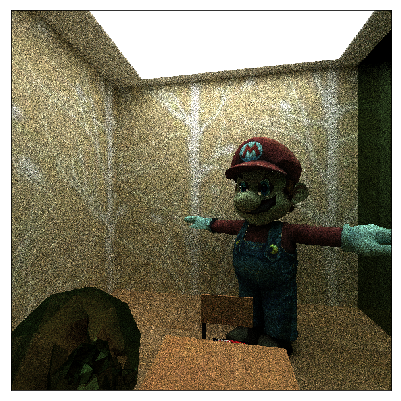

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


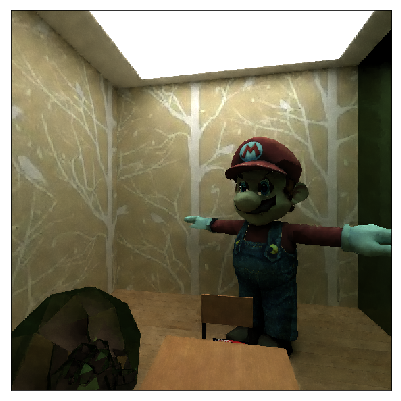

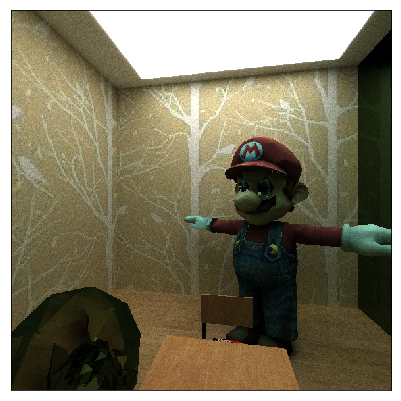

LossDiff: 0.011548048816621304
LossSpec: 0.011063514277338982


In [63]:
torch.cuda.empty_cache()
denoise(modeld, models, eval_data, debug=True)